# Import Packages

In [1]:
# Import packages
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
logs_df = pd.read_csv("../Data Cleaning/cleaned_dataset.csv")
logs_df

,SEX,AGE,RXASP,RXHEP,FDEAD,FDENNIS,FRECOVER,RXHEP_1,TREATMENT,REWARD_BERNOULLI,REWARD_CATEGORICAL,REWARD_VALUE (BER),REWARD_VALUE (CAT)
0,M,YOUNG,Y,L,N,U,U,L,4,Alive,Alive with unknown status,1,1
1,M,OLD,Y,L,Y,NaN,NaN,L,4,Dead,Dead,0,0
2,M,OLD,N,N,Y,NaN,NaN,N,1,Dead,Dead,0,0
3,M,YOUNG,Y,N,N,Y,N,N,3,Alive,Alive and still dependent,1,2
4,F,YOUNG,Y,N,N,N,Y,N,3,Alive,Alive and recovered,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,F,OLD,N,N,N,N,N,N,1,Alive,Alive and recovered,1,3
2496,M,OLD,Y,N,Y,NaN,NaN,N,3,Dead,Dead,0,0
2497,F,OLD,N,L,N,N,N,L,2,Alive,Alive and recovered,1,3
2498,M,YOUNG,Y,L,Y,NaN,NaN,L,4,Dead,Dead,0,0


In [3]:
# Generate a list of 2500 tuples of gender and age values
# AGE: OLD = 1, YOUNG = 0
logs_df.loc[logs_df['AGE'] == 'OLD', 'AGE_new'] = 1
logs_df.loc[logs_df['AGE'] == 'YOUNG', 'AGE_new'] = 0
logs_df["AGE_new"] = logs_df["AGE_new"].astype(int)
# GENDER: M = 1, F = 0
logs_df.loc[logs_df['SEX'] == 'M', 'SEX_new'] = 1
logs_df.loc[logs_df['SEX'] == 'F', 'SEX_new'] = 0
logs_df["SEX_new"] = logs_df["SEX_new"].astype(int)

gender_list = logs_df['SEX_new'].to_numpy()
age_list = logs_df['AGE_new'].to_numpy()

gender_age_list = list(zip(gender_list, age_list))
gender_age_list = np.array(gender_age_list)
gender_age_list


array([[1, 0],
       [1, 1],
       [1, 1],
       ...,
       [0, 1],
       [1, 0],
       [0, 1]])

# Algorithms

In [4]:
class LinUCB:
    def __init__(self, n_arms, n_features, alpha):
        self.n_arms = n_arms
        self.n_features = n_features
        self.alpha = alpha
        self.A = [np.identity(n_features) for _ in range(n_arms)]
        self.b = [np.zeros(n_features) for _ in range(n_arms)]

    def update(self, arm, x_t, reward):
        self.A[arm] += np.outer(x_t, x_t)
        self.b[arm] += reward * x_t

    def recommend(self, x_t):
        scores = np.zeros(self.n_arms)
        thetas = [np.zeros(self.n_features) for _ in range(self.n_arms)]
        for arm in range(self.n_arms):
            A_inv = np.linalg.inv(self.A[arm])
            theta = A_inv @ self.b[arm]
            p_arm = theta.T @ x_t + self.alpha * np.sqrt(x_t.T @ A_inv @ x_t)
            scores[arm] = p_arm
            thetas[arm] = theta
        return np.argmax(scores), thetas, scores

In [5]:
class LinThompsonSampling:
    def __init__(self, n_arms, n_features, alpha):
        self.n_arms = n_arms
        self.n_features = n_features
        self.B = [np.identity(n_features) for _ in range(n_arms)] 
        self.mu_hat = [np.zeros(n_features) for _ in range(n_arms)]
        self.f = [np.zeros(n_features) for _ in range(n_arms)]
        self.alpha = alpha
        # self.v = R * np.sqrt(24 / epsilon * n_features * np.log(1 / delta))

    def update(self, arm, x_t, reward):
        self.B[arm] += x_t.dot(x_t.T)
        self.f[arm] += reward*x_t
        self.mu_hat[arm] = np.linalg.inv(self.B[arm]).dot(self.f[arm])

    def recommend(self, x_t):
        scores = np.zeros(self.n_arms)
        thetas = [np.zeros(self.n_features) for _ in range(self.n_arms)]
        for arm in range(self.n_arms):
            mu_tilde = np.random.multivariate_normal(self.mu_hat[arm].flat, self.alpha**2 * np.linalg.inv(self.B[arm]))[..., np.newaxis]
            # theta = 1/(1+np.exp(-1 * self.f[arm]))
            theta = 1/(1+np.exp(-1 * self.B[arm].dot(self.mu_hat[arm])))
            scores[arm] = x_t.dot(mu_tilde)
            thetas[arm] = theta
        return np.argmax(scores), thetas, scores

# Simulation and Tuning

In [6]:
def simulate_one_time_reward(arm, x_t, theta, scale_noise = 0.01):
    signal = theta @ x_t
    noise  = np.random.normal(scale = scale_noise) 
    return (signal + noise)

In [7]:
# Implement Simulation Test
def test_algorithm(algo, n_arms, n_features, n_sims, n_steps, alpha, gender_age_list):
    chosen_arms = [0 for i in range(n_sims * n_steps)]
    rewards = [0 for i in range(n_sims * n_steps)]
    cumulative_rewards = [0 for i in range(n_sims * n_steps)]
    sim_rounds = [0 for i in range(n_sims * n_steps)]
    time_steps = [0 for i in range(n_sims * n_steps)]
    
    for sim in range(n_sims):
        sim = sim + 1
        
        for t in range(n_steps):
            x_t = gender_age_list[t]
            t = t + 1
            index = (sim-1) * n_steps + t - 1
            sim_rounds[index] = sim
            time_steps[index] = t
            
            chosen_arm, thetas, scores = algo.recommend(x_t)
            chosen_arms[index] = chosen_arm + 1
            
            theta = thetas[chosen_arm]
            
            reward = simulate_one_time_reward(chosen_arm + 1, x_t, theta, scale_noise = 0.01)
            rewards[index] = reward
            
            if t == 1:
                cumulative_rewards[index] = reward
            else:
                cumulative_rewards[index] = cumulative_rewards[index - 1] + reward 
            
            algo.update(chosen_arm, x_t, reward)

    return (sim_rounds, time_steps, chosen_arms, rewards, cumulative_rewards)

## LinUCB

In [8]:
n_steps = gender_age_list.shape[0]
n_sims = 1000
alpha_values = [0.1, 0.5, 1, 5, 10]
num_features = 2
num_arms = 4
all_results_linUCB = pd.DataFrame(columns = ["n_sim", "n_step", "chosen_treatment", "rewards", "cumulative_rewards"])

In [9]:
for alpha in alpha_values:
    linUCB_algo = LinUCB(num_arms, num_features, alpha)
    results_linUCB = pd.DataFrame(test_algorithm(linUCB_algo, num_arms, num_features, 
                                                  n_sims, n_steps, alpha, gender_age_list)).transpose()
    results_linUCB.columns = ["n_sim", "n_step", "chosen_treatment", "rewards", "cumulative_rewards"]
    results_linUCB["alpha"] = alpha
    all_results_linUCB = pd.concat([all_results_linUCB, results_linUCB])

In [10]:
all_results_linUCB["n_sim"] = all_results_linUCB["n_sim"].astype(int)
all_results_linUCB["n_step"] = all_results_linUCB["n_step"].astype(int)
all_results_linUCB["chosen_treatment"] = all_results_linUCB["chosen_treatment"].astype(int)
all_results_linUCB = all_results_linUCB.reset_index(drop = True)

In [11]:
all_results_linUCB

,n_sim,n_step,chosen_treatment,rewards,cumulative_rewards,alpha
0,1,1,1,-0.000389,-0.000389,0.1
1,1,2,2,-0.018739,-0.019129,0.1
2,1,3,3,0.006771,-0.012358,0.1
3,1,4,4,-0.001895,-0.014253,0.1
4,1,5,1,-0.007512,-0.021765,0.1
...,...,...,...,...,...,...
12499995,1000,2496,1,0.007346,14.025100,10.0
12499996,1000,2497,1,-0.011895,14.013205,10.0
12499997,1000,2498,1,0.025672,14.038876,10.0
12499998,1000,2499,4,-0.006174,14.032702,10.0


In [12]:
success_probabilities_linUCB = [0.6, 0.2, 0.7, 0.9]

all_results_linUCB['if_best_treatment'] = np.where(all_results_linUCB['chosen_treatment'] == success_probabilities_linUCB.index(max(success_probabilities_linUCB)), 1, 0)

# Group by alpha and n_step
results_plot_linUCB = all_results_linUCB.groupby(['alpha', 'n_step'], as_index = False).aggregate({'if_best_treatment': lambda x: x.sum() / float(x.count()), "rewards":"mean", "cumulative_rewards":"mean"})

In [13]:
results_plot_linUCB

,alpha,n_step,if_best_treatment,rewards,cumulative_rewards
0,0.1,1,0.000,0.003754,0.003754
1,0.1,2,0.999,0.019147,0.022901
2,0.1,3,1.000,0.017569,0.040470
3,0.1,4,0.000,0.003959,0.044429
4,0.1,5,0.000,0.000058,0.044487
...,...,...,...,...,...
12495,10.0,2496,0.204,0.008170,10.400277
12496,10.0,2497,0.083,0.003794,10.404070
12497,10.0,2498,0.186,0.008584,10.412654
12498,10.0,2499,0.082,-0.000256,10.412398


### Rewards

Text(0.5, 1.0, 'The probability of choosing the best treatment')

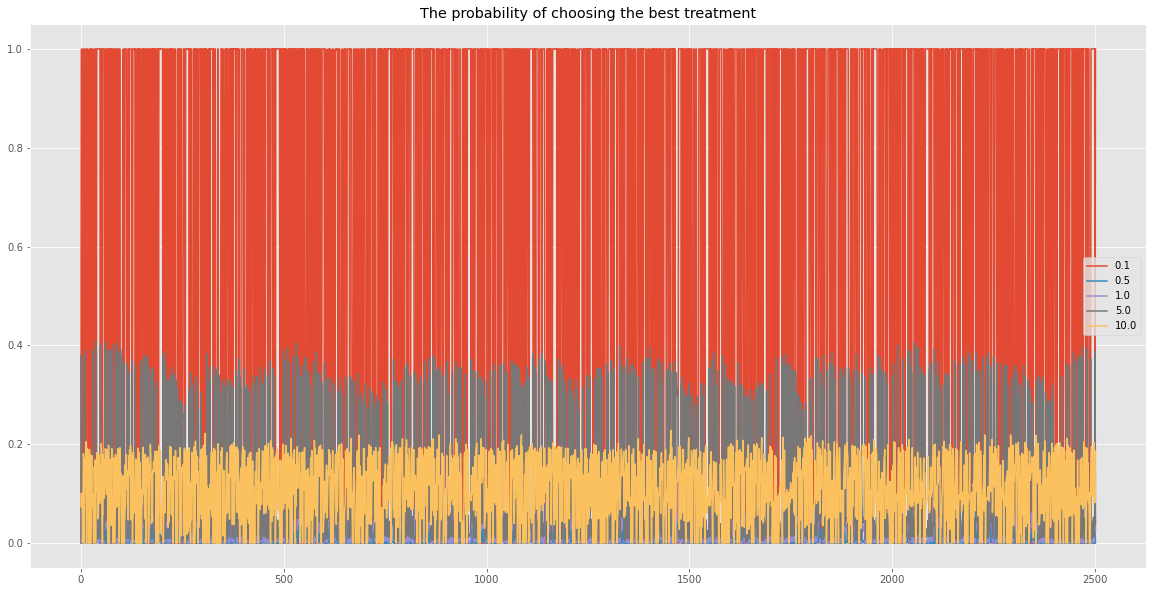

In [14]:
plt.style.use('ggplot')

# Plot the probability of choosing the best movie
fig = plt.figure(figsize = (20, 10))
ax = fig.add_subplot(111)
for alpha in results_plot_linUCB['alpha'].unique():
    results_linUCB = results_plot_linUCB[results_plot_linUCB['alpha'] == alpha]
    ax.plot(results_linUCB['n_step'], results_linUCB['if_best_treatment'], label = str(alpha))

plt.legend() 
plt.title("The probability of choosing the best treatment")

Text(0.5, 1.0, 'Average rewards at each time step')

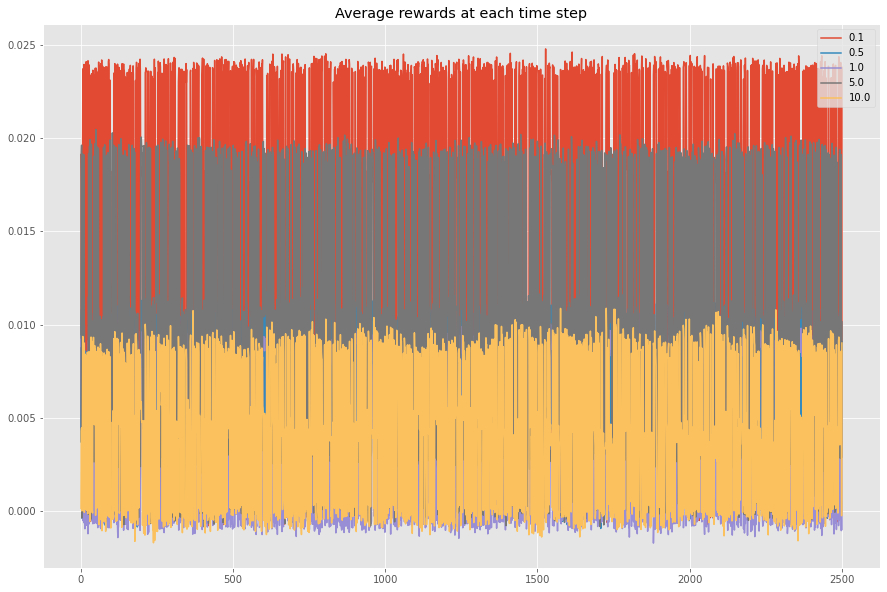

In [15]:
# plot the rewards at each time step
plt.style.use('ggplot')

fig = plt.figure(figsize = (15, 10))
ax = fig.add_subplot(111)

for alpha in results_plot_linUCB['alpha'].unique():
    results_linUCB = results_plot_linUCB[results_plot_linUCB['alpha'] == alpha]
    ax.plot(results_linUCB['n_step'], results_linUCB['rewards'], label = str(alpha))

plt.legend()
plt.title("Average rewards at each time step")

In [16]:
# Determine the cumulative reward at 1000 time step
results_plot_linUCB[results_plot_linUCB["n_step"] == 2500].sort_values(by=["cumulative_rewards"], ascending = False)

,alpha,n_step,if_best_treatment,rewards,cumulative_rewards
2499,0.1,2500,1.000,0.023794,35.266927
9999,5.0,2500,0.039,0.002888,22.757354
4999,0.5,2500,0.001,0.009076,16.872549
7499,1.0,2500,0.023,-0.000993,11.555412
12499,10.0,2500,0.186,0.009010,10.421407


Text(0.5, 1.0, 'Cumulative rewards at each step')

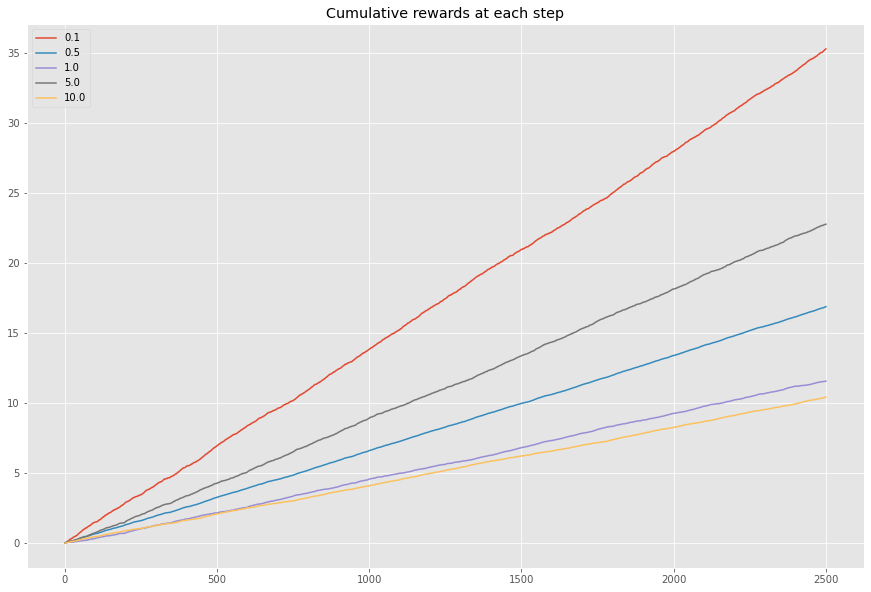

In [17]:
# Plot the cumulative rewards at each time step
plt.style.use('ggplot')

fig = plt.figure(figsize = (15, 10))
ax = fig.add_subplot(111)
    
for alpha in results_plot_linUCB['alpha'].unique():
    results_linUCB = results_plot_linUCB[results_plot_linUCB['alpha'] == alpha]
    ax.plot(results_linUCB['n_step'], results_linUCB['cumulative_rewards'], label = str(alpha))

plt.legend()
plt.title("Cumulative rewards at each step")

## Lin Thompson Sampling

In [18]:
# all_results_linTS = pd.DataFrame(columns = ["n_sim", "n_step", "chosen_treatment", "rewards", "cumulative_rewards"])
# R_values = [0.01, 0.1]
# epsilon_values = [0.1, 0.5, 0.9]
# delta = 0.5
# # alpha_values = [0.1, 1, 10, 100, 1000]
# alpha_values = []

# for R in R_values:
#     for epsilon in epsilon_values:
#         alpha_value = R * np.sqrt(24 / epsilon * num_features * np.log(1 / delta))
#         alpha_values.append(alpha_value)

In [19]:
# for alpha in alpha_values:
#     linTS_algo = LinThompsonSampling(num_arms, num_features, alpha)
#     results_linTS = pd.DataFrame(test_algorithm(linTS_algo, num_arms, num_features, 
#                                                 n_sims, n_steps, alpha, gender_age_list)).transpose()
#     results_linTS.columns = ["n_sim", "n_step", "chosen_treatment", "rewards", "cumulative_rewards"]
#     results_linTS["alpha"] = alpha
#     all_results_linTS = pd.concat([all_results_linTS, results_linTS])

In [20]:
# all_results_linTS["n_sim"] = all_results_linTS["n_sim"].astype(int)
# all_results_linTS["n_step"] = all_results_linTS["n_step"].astype(int)
# all_results_linTS["chosen_treatment"] = all_results_linTS["chosen_treatment"].astype(int)
# all_results_linTS = all_results_linTS.reset_index(drop = True)

In [21]:
# all_results_linTS

In [22]:
# all_results_linTS['if_best_treatment'] = np.where(all_results_linTS['chosen_treatment'] == success_probabilities_linUCB.index(max(success_probabilities_linUCB)), 1, 0)

# # Group by n_step
# results_plot_linTS = all_results_linTS.groupby(['alpha', 'n_step'], as_index = False).aggregate({'if_best_treatment': lambda x: x.sum() / float(x.count()), "rewards":"mean", "cumulative_rewards":"mean"})

In [23]:
# results_plot_linTS

### Rewards

In [24]:
# plt.style.use('ggplot')

# # Plot the probability of choosing the best treatment
# fig = plt.figure(figsize = (20, 10))
# ax = fig.add_subplot(111)
# for alpha in results_plot_linTS['alpha'].unique():
#     results_linTS = results_plot_linTS[results_plot_linTS['alpha'] == alpha]
#     ax.plot(results_linTS['n_step'], results_linTS['if_best_treatment'], label = str(alpha))

# plt.legend() 
# plt.title("The probability of choosing the best treatment")

In [25]:
# plt.style.use('ggplot')

# # Plot the probability of choosing the best treatment
# fig = plt.figure(figsize = (20, 10))
# ax = fig.add_subplot(111)
# for alpha in results_plot_linTS['alpha'].unique():
#     results_linTS = results_plot_linTS[results_plot_linTS['alpha'] == alpha]
#     ax.plot(results_linTS['n_step'], results_linTS['rewards'], label = str(alpha))

# plt.legend() 
# plt.title("Average rewards at each time step")

In [26]:
# Determine the cumulative reward at 1000 time step
# results_plot_linTS[results_plot_linTS["n_step"] == 2500].sort_values(by=["cumulative_rewards"], ascending = False)

In [27]:
# plt.style.use('ggplot')

# # Plot the probability of choosing the best treatment
# fig = plt.figure(figsize = (15, 10))
# ax = fig.add_subplot(111)
# for alpha in results_plot_linTS['alpha'].unique():
#     results_linTS = results_plot_linTS[results_plot_linTS['alpha'] == alpha]
#     ax.plot(results_linTS['n_step'], results_linTS['cumulative_rewards'], label = str(alpha))

# plt.legend() 
# plt.title("Cumulative rewards at each step")